In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from pytorch_msssim import ssim
from torch.utils.data import random_split

In [ ]:
HR_DIR = "dataset/DIV2K_train_HR/"
LR_DIR = "dataset/DIV2K_train_LR_bicubic/X4/"

PATCH_SIZE = 48 
BATCH_SIZE = 8  
EPOCHS = 30     
LR = 1e-3       

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class SRCNNDataset(torch.utils.data.Dataset):
    def __init__(self, hr_dir, lr_dir, patch=32, augment=True):
        self.hr_images = sorted(os.listdir(hr_dir))
        self.hr_dir = hr_dir
        self.lr_dir = lr_dir
        self.patch = patch
        self.augment = augment

    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        hr = cv2.imread(os.path.join(self.hr_dir, self.hr_images[idx]))
        lr = cv2.imread(os.path.join(self.lr_dir, self.hr_images[idx].replace(".png", "x4.png")))

        hr = cv2.cvtColor(hr, cv2.COLOR_BGR2YCrCb)[:, :, 0]
        lr = cv2.cvtColor(lr, cv2.COLOR_BGR2YCrCb)[:, :, 0]

        h, w = lr.shape
        x = np.random.randint(0, h - self.patch)
        y = np.random.randint(0, w - self.patch)

        lr_patch = lr[x:x+self.patch, y:y+self.patch]
        
        hr_patch = hr[x*4:x*4+self.patch*4, y*4:y*4+self.patch*4]
        
        if self.augment:

            if np.random.rand() > 0.5:
                lr_patch = np.fliplr(lr_patch)
                hr_patch = np.fliplr(hr_patch)
            
            if np.random.rand() > 0.5:
                lr_patch = np.flipud(lr_patch)
                hr_patch = np.flipud(hr_patch)
            
            k = np.random.randint(0, 4)

            if k > 0:
                lr_patch = np.rot90(lr_patch, k)
                hr_patch = np.rot90(hr_patch, k)
        
        lr_upscaled = cv2.resize(lr_patch, (self.patch*4, self.patch*4), interpolation=cv2.INTER_CUBIC)

        hr_patch = torch.tensor(hr_patch / 255.).float().unsqueeze(0)
        lr_upscaled = torch.tensor(lr_upscaled / 255.).float().unsqueeze(0)

        return lr_upscaled, hr_patch

In [ ]:
full_dataset = SRCNNDataset(HR_DIR, LR_DIR, PATCH_SIZE, augment=True)

train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_set, val_set = random_split(full_dataset, [train_size, val_size])

val_set.dataset.augment = False

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

# print(f"Training samples: {train_size}")
# print(f"Validation samples: {val_size}")

Training samples: 720
Validation samples: 80


In [ ]:
class ImprovedSRCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
        self.act1 = nn.PReLU()

        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
        self.act2 = nn.PReLU()

        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.act3 = nn.PReLU()

        self.conv4 = nn.Conv2d(16, 1, kernel_size=5, padding=2)

        self.res_scale = 0.1

    def forward(self, x):
        identity = x

        out = self.act1(self.conv1(x))
        out = self.act2(self.conv2(out))
        out = self.act3(self.conv3(out))
        out = self.conv4(out)

        return identity + self.res_scale * out

In [7]:
model = ImprovedSRCNN().to(DEVICE)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 61,508


In [8]:
def psnr(sr, hr):
    mse = torch.mean((sr - hr) ** 2)
    return 10 * math.log10(1 / mse.item())

In [ ]:
def calc_ssim(sr, hr):
    return ssim(sr, hr, data_range=1.0, size_average=True).item()

In [ ]:
l1_loss = nn.L1Loss()

def combined_loss(sr, hr):
    return l1_loss(sr, hr) + 0.1 * (1 - ssim(sr, hr, data_range=1.0))

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

train_losses = []
val_losses = []
train_ssim_scores = []
val_ssim_scores = []
best_val_loss = float('inf')
patience_counter = 0
early_stop_patience = 10 

print("Starting training with validation...")
for epoch in range(EPOCHS):

    model.train()
    epoch_train_loss = 0
    
    for batch_idx, (lr_img, hr_img) in enumerate(train_loader):
        lr_img, hr_img = lr_img.to(DEVICE), hr_img.to(DEVICE)

        sr = model(lr_img)
        loss = combined_loss(sr, hr_img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    with torch.no_grad():
        train_lr, train_hr = next(iter(train_loader))
        train_lr, train_hr = train_lr.to(DEVICE), train_hr.to(DEVICE)
        train_sr = model(train_lr)
        epoch_train_ssim = calc_ssim(train_sr, train_hr)
        train_ssim_scores.append(epoch_train_ssim)
    
    model.eval()
    epoch_val_loss = 0
    epoch_val_ssim = 0
    
    with torch.no_grad():
        for val_lr, val_hr in val_loader:
            val_lr, val_hr = val_lr.to(DEVICE), val_hr.to(DEVICE)
            val_sr = model(val_lr)
            val_loss = combined_loss(val_sr, val_hr)
            epoch_val_loss += val_loss.item()
            epoch_val_ssim += calc_ssim(val_sr, val_hr)
    
    avg_val_loss = epoch_val_loss / len(val_loader)
    avg_val_ssim = epoch_val_ssim / len(val_loader)
    val_losses.append(avg_val_loss)
    val_ssim_scores.append(avg_val_ssim)
    
    scheduler.step(avg_val_loss)
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), './models/best_improved_srcnn_model.pth')
        print(f"  Epoch [{epoch+1}/{EPOCHS}] Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | Val SSIM: {avg_val_ssim:.4f} | **BEST MODEL SAVED**")
    else:
        patience_counter += 1
        print(f"  Epoch [{epoch+1}/{EPOCHS}] Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | Val SSIM: {avg_val_ssim:.4f}")
    
    if patience_counter >= early_stop_patience:
        print(f"\n  Early stopping triggered! No improvement for {early_stop_patience} epochs.")
        print(f"Best validation loss: {best_val_loss:.6f}")
        break

print("\n  Training completed!")
print(f"Best validation loss: {best_val_loss:.6f}")

Starting training with validation...
✓ Epoch [1/30] Train Loss: 0.054137 | Val Loss: 0.049993 | Val SSIM: 0.7751 | **BEST MODEL SAVED**
  Epoch [2/30] Train Loss: 0.051331 | Val Loss: 0.050039 | Val SSIM: 0.7798
✓ Epoch [3/30] Train Loss: 0.052159 | Val Loss: 0.041953 | Val SSIM: 0.8144 | **BEST MODEL SAVED**
  Epoch [4/30] Train Loss: 0.051087 | Val Loss: 0.045036 | Val SSIM: 0.8032
  Epoch [5/30] Train Loss: 0.051547 | Val Loss: 0.047054 | Val SSIM: 0.7952
  Epoch [6/30] Train Loss: 0.051358 | Val Loss: 0.045958 | Val SSIM: 0.7949
✓ Epoch [7/30] Train Loss: 0.051358 | Val Loss: 0.040814 | Val SSIM: 0.8194 | **BEST MODEL SAVED**
  Epoch [8/30] Train Loss: 0.052080 | Val Loss: 0.044897 | Val SSIM: 0.7986
  Epoch [9/30] Train Loss: 0.049856 | Val Loss: 0.047069 | Val SSIM: 0.7974
  Epoch [10/30] Train Loss: 0.051987 | Val Loss: 0.049366 | Val SSIM: 0.7844
  Epoch [11/30] Train Loss: 0.051178 | Val Loss: 0.045363 | Val SSIM: 0.7998
  Epoch [12/30] Train Loss: 0.052433 | Val Loss: 0.04429

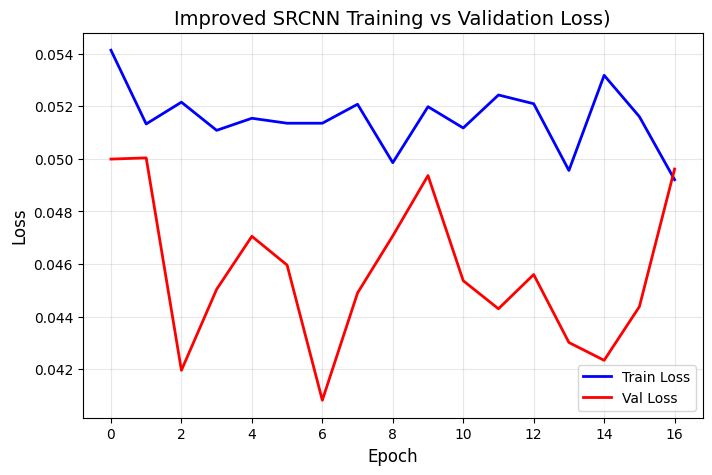

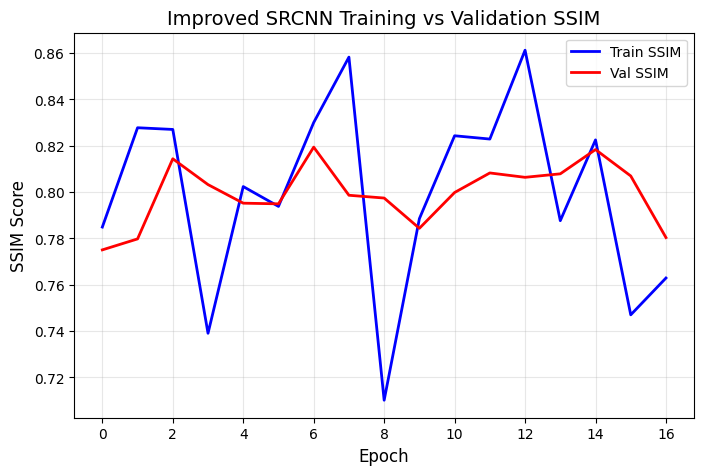

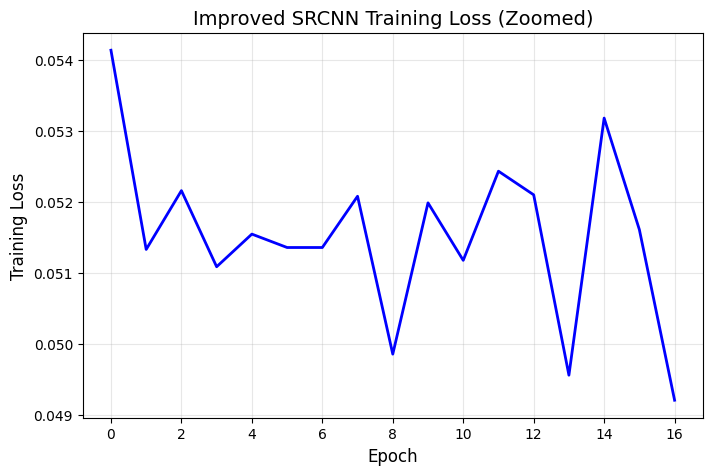

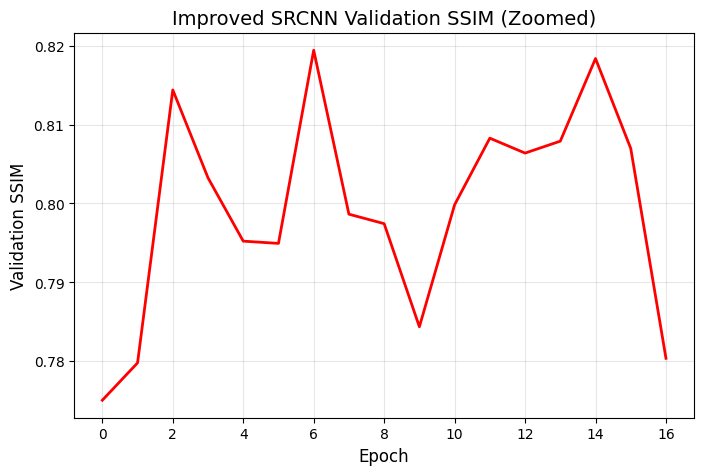


Final Train SSIM: 0.7629
Final Val SSIM: 0.7804
Best Val SSIM: 0.8194


In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, linewidth=2, color='blue', label='Train Loss')
plt.plot(val_losses, linewidth=2, color='red', label='Val Loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Improved SRCNN Training vs Validation Loss', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(train_ssim_scores, linewidth=2, color='blue', label='Train SSIM')
plt.plot(val_ssim_scores, linewidth=2, color='red', label='Val SSIM')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('SSIM Score', fontsize=12)
plt.title('Improved SRCNN Training vs Validation SSIM', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(train_losses, linewidth=2, color='blue')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.title('Improved SRCNN Training Loss (Zoomed)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(val_ssim_scores, linewidth=2, color='red')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Validation SSIM', fontsize=12)
plt.title('Improved SRCNN Validation SSIM (Zoomed)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal Train SSIM: {train_ssim_scores[-1]:.4f}")
print(f"Final Val SSIM: {val_ssim_scores[-1]:.4f}")
print(f"Best Val SSIM: {max(val_ssim_scores):.4f}")

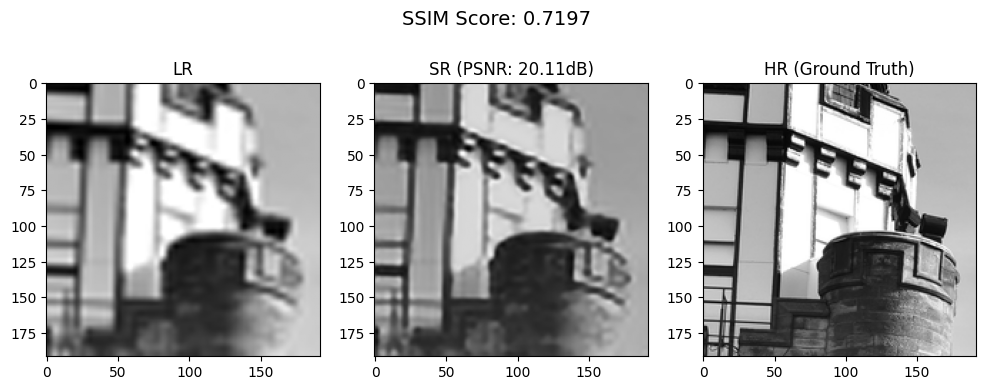

In [ ]:
lr, hr = train_set[0]
with torch.no_grad():
    lr_batch = lr.unsqueeze(0).to(DEVICE)
    sr = model(lr_batch).cpu().squeeze()
    
    hr_batch = hr.unsqueeze(0)
    sr_batch = sr.unsqueeze(0).unsqueeze(0)
    sample_ssim = calc_ssim(sr_batch, hr_batch)
    sample_psnr = psnr(sr_batch, hr_batch)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("LR"); plt.imshow(lr.squeeze(), cmap="gray")
plt.subplot(1,3,2); plt.title(f"SR (PSNR: {sample_psnr:.2f}dB)"); plt.imshow(sr, cmap="gray")
plt.subplot(1,3,3); plt.title("HR (Ground Truth)"); plt.imshow(hr.squeeze(), cmap="gray")
plt.suptitle(f"SSIM Score: {sample_ssim:.4f}", fontsize=14, y=1.02)
plt.show()

## Load Saved Model and Upscale User Images

In [ ]:
import pickle

def load_srcnn_model(model_path='srcnn_model.pkl'):

    with open(model_path, 'rb') as f:
        model_data = pickle.load(f)
    
    model_class = model_data['model_class']
    model = model_class()
    model.load_state_dict(model_data['model_state_dict'])
    model.eval() 
    
    best_loss = model_data.get('best_val_loss', model_data.get('best_loss', 'N/A'))
    print(f"Best validation loss: {best_loss if isinstance(best_loss, str) else f'{best_loss:.6f}'}")
    print(f"Trained for {model_data['epochs']} epochs")
    print(f"Scale factor: {model_data['scale_factor']}x")
    
    return model, model_data

def upscale_image(model, image_path, device='cpu', scale_factor=4):

    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image: {image_path}")
    
    img_ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    y_channel = img_ycrcb[:, :, 0]
    
    h, w = y_channel.shape
    y_bicubic = cv2.resize(y_channel, (w * scale_factor, h * scale_factor), 
                           interpolation=cv2.INTER_CUBIC)
    
    y_tensor = torch.tensor(y_bicubic / 255.).float().unsqueeze(0).unsqueeze(0)
    y_tensor = y_tensor.to(device)
    
    model = model.to(device)
    with torch.no_grad():
        sr_y = model(y_tensor).cpu().squeeze().numpy()
    
    sr_y = np.clip(sr_y * 255., 0, 255).astype(np.uint8)
    
    cr_channel = cv2.resize(img_ycrcb[:, :, 1], (w * scale_factor, h * scale_factor), 
                           interpolation=cv2.INTER_CUBIC)
    cb_channel = cv2.resize(img_ycrcb[:, :, 2], (w * scale_factor, h * scale_factor), 
                           interpolation=cv2.INTER_CUBIC)
    
    sr_ycrcb = np.stack([sr_y, cr_channel, cb_channel], axis=2)
    sr_bgr = cv2.cvtColor(sr_ycrcb, cv2.COLOR_YCrCb2BGR)
    
    return sr_bgr, y_bicubic

loaded_model, model_info = load_srcnn_model('improved_srcnn_model.pkl')

Best validation loss: 0.040814
Trained for 17 epochs
Scale factor: 4x



Image Quality Metrics:
Bicubic   - PSNR: 23.97 dB | SSIM: 0.6164
SRCNN     - PSNR: 24.16 dB | SSIM: 0.6436
Improvement - PSNR: +0.19 dB | SSIM: +0.0272



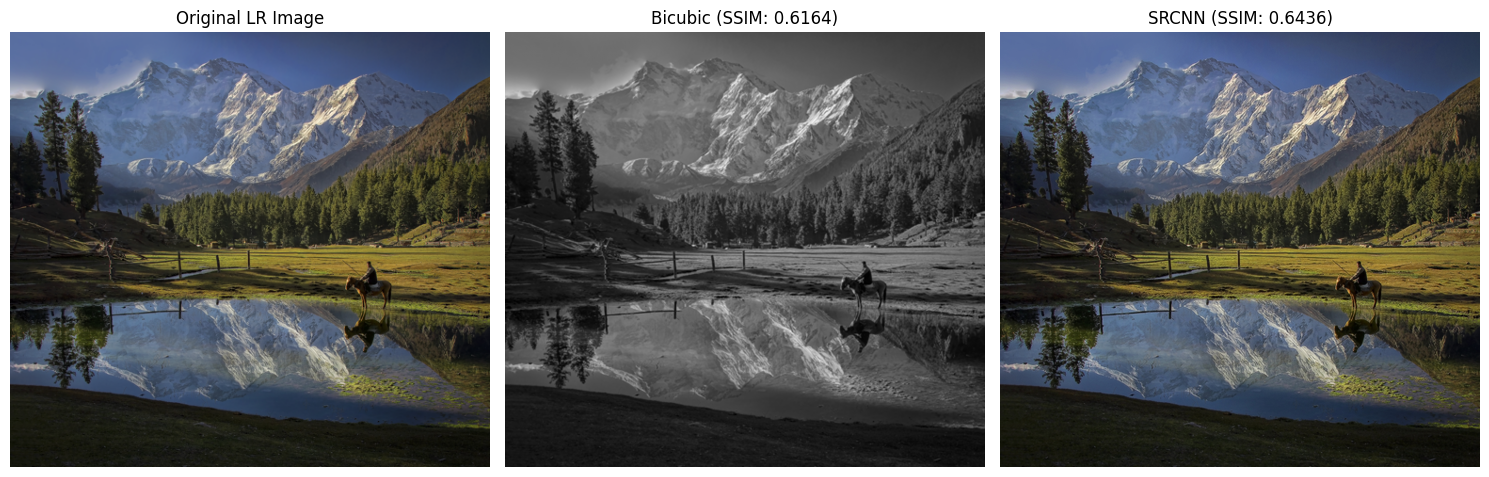

✓ Super-resolved image saved as 'output_super_resolution.png'


In [ ]:
test_lr_path = "dataset/DIV2K_train_LR_bicubic/X4/0002x4.png"
test_hr_path = test_lr_path.replace("LR_bicubic/X4", "HR").replace("x4", "")

sr_image, bicubic_image = upscale_image(loaded_model, test_lr_path, device=DEVICE, scale_factor=4)

lr_original = cv2.imread(test_lr_path)
hr_original = cv2.imread(test_hr_path)

if hr_original is not None:

    sr_y = cv2.cvtColor(sr_image, cv2.COLOR_BGR2YCrCb)[:, :, 0]
    hr_y = cv2.cvtColor(hr_original, cv2.COLOR_BGR2YCrCb)[:, :, 0]
    bicubic_y = bicubic_image
    
    sr_tensor = torch.tensor(sr_y / 255.).float().unsqueeze(0).unsqueeze(0)
    hr_tensor = torch.tensor(hr_y / 255.).float().unsqueeze(0).unsqueeze(0)
    bicubic_tensor = torch.tensor(bicubic_y / 255.).float().unsqueeze(0).unsqueeze(0)
    
    srcnn_ssim = calc_ssim(sr_tensor, hr_tensor)
    bicubic_ssim = calc_ssim(bicubic_tensor, hr_tensor)
    srcnn_psnr = psnr(sr_tensor, hr_tensor)
    bicubic_psnr = psnr(bicubic_tensor, hr_tensor)
    
    print(f"\n{'='*50}")
    print(f"Image Quality Metrics:")
    print(f"{'='*50}")
    print(f"Bicubic   - PSNR: {bicubic_psnr:.2f} dB | SSIM: {bicubic_ssim:.4f}")
    print(f"SRCNN     - PSNR: {srcnn_psnr:.2f} dB | SSIM: {srcnn_ssim:.4f}")
    print(f"Improvement - PSNR: +{srcnn_psnr-bicubic_psnr:.2f} dB | SSIM: +{srcnn_ssim-bicubic_ssim:.4f}")
    print(f"{'='*50}\n")

fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(lr_original, cv2.COLOR_BGR2RGB))
plt.title("Original LR Image", fontsize=12)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(bicubic_image, cmap='gray')
if hr_original is not None:
    plt.title(f"Bicubic (SSIM: {bicubic_ssim:.4f})", fontsize=12)
else:
    plt.title("Bicubic Upscale", fontsize=12)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(sr_image, cv2.COLOR_BGR2RGB))
if hr_original is not None:
    plt.title(f"SRCNN (SSIM: {srcnn_ssim:.4f})", fontsize=12)
else:
    plt.title("SRCNN Super-Resolution", fontsize=12)
plt.axis('off')

plt.tight_layout()
plt.show()

output_path = "output_improved_super_resolution.png"
cv2.imwrite(output_path, sr_image)
print(f"✓ Super-resolved image saved as '{output_path}'")